# Importing required libraries

In [5]:
!pip install IPython

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from IPython.display import HTML

# Storing data into tensorflow dataset

In [33]:
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=24,
)

Found 16011 files belonging to 10 classes.


In [10]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [11]:
len(dataset)

501

In [12]:
501*32

16032

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 7 7 6 6 0 0 1 7 3 5 0 2 1 5 4 4 7 2 7 0 7 2 5 9 7 9 5 5 8 7]


# Visualization of an image from the tf dataset

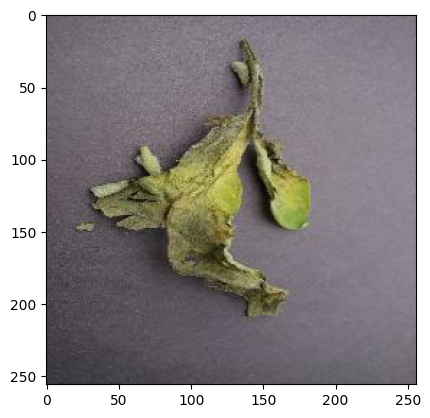

In [14]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [15]:
EPOCHS = 50 #model will see the same image 50 times

# Train test split

**80%** training set <br>
**10%** validation set <br>
**10%** test set

In [16]:
def get_partitioned_datasets(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
    if shuffle:
        dataset=dataset.shuffle(shuffle_size, seed = 10)
        
    dataset_len = len(dataset)  

    train_len = int(train_split*dataset_len)
    train_dataset = dataset.take(train_len)
    dataset = dataset.skip(train_len)

    val_len = int(dataset_len*val_split)
    val_dataset = dataset.take(val_len)
    dataset = dataset.skip(val_len)

    test_len = dataset_len - train_len - val_len
    test_dataset = dataset.take(test_len)
    
    
    return train_dataset, val_dataset, test_dataset

In [17]:
train_dataset, val_dataset, test_dataset = get_partitioned_datasets(dataset)

In [18]:
len(train_dataset)

400

In [19]:
len(val_dataset)

50

In [20]:
len(test_dataset)

51

prefetch() is used when the GPU is training one batch, at the same time the CPU will train another batch so it will take less time

In [21]:
train_dataset  = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset  = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset  = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Augmentation

In [22]:
ONE_IMAGE_SIZE = 256

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(ONE_IMAGE_SIZE, ONE_IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

In [34]:
CHANNELS = 3
input_shape = (BATCH_SIZE, ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# I have deleted two pairs of (2nd Conv2D and MaxPooling2D)

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (16, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (16, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (16, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (16, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (16, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (16, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (16, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (16, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (16, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (16, 12544)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (16, 64)                    │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (16, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,778 (3.42 MB)

 Trainable params: 896,778 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=8
)

Epoch 1/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 91s 212ms/step - accuracy: 0.4866 - loss: 1.4616 - val_accuracy: 0.8144 - val_loss: 0.5729
Epoch 2/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 85s 211ms/step - accuracy: 0.8043 - loss: 0.5742 - val_accuracy: 0.8737 - val_loss: 0.3955
Epoch 3/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 171ms/step - accuracy: 0.8520 - loss: 0.4307 - val_accuracy: 0.8975 - val_loss: 0.3152
Epoch 4/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 66s 166ms/step - accuracy: 0.9056 - loss: 0.2668 - val_accuracy: 0.9212 - val_loss: 0.2161
Epoch 5/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 69s 172ms/step - accuracy: 0.9280 - loss: 0.2104 - val_accuracy: 0.9131 - val_loss: 0.2492
Epoch 6/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.9419 - loss: 0.1598 - val_accuracy: 0.9250 - val_loss: 0.1999
Epoch 7/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 72s 180ms/step - accuracy: 0.9653 - loss: 0.1009 - val_accuracy: 0.9575 - val_loss: 0.1201
Epoch 8/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.9711 - loss: 0.0850 - 

In [41]:
model.evaluate(test_dataset)

51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9704 - loss: 0.0956


[0.09238717705011368, 0.9718137383460999]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 8, 'steps': 400}

The first image:
The first image's actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
The predicted label: Tomato_Bacterial_spot


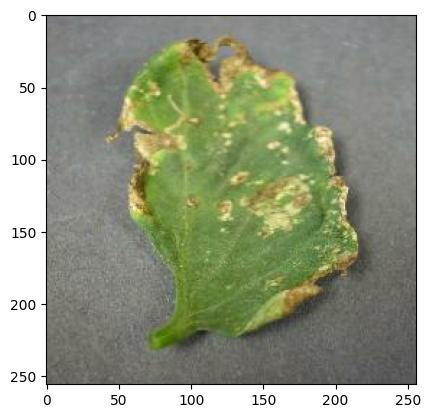

In [51]:
for image_batch, label_batch in test_dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]

    print("The first image:")
    plt.imshow(first_image)
    print("The first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("The predicted label:", class_names[np.argmax(batch_prediction[0])])